In [1]:
from src.data import save_imgs_list_2npy
import os
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from tqdm import tqdm
import optuna
import datetime
import pickle

import torch
from torch.utils.data import DataLoader

from src import data, evaluate, model, preprocessing, visualization
from src.lib import utils
from src.data import MontevideoDataset, MontevideoFoldersDataset
from src.dl_models.unet import UNet

PATH_PROJECT = 'C:/Users/Ignacio/Desktop/Facultad/2021/proyecto/'
#PATH_PROJECT = '/clusteruy/home03/DeepCloud/deepCloud/'
#PATH_PROJECT = ''
PATH_DATA = os.path.join(PATH_PROJECT, 'data/mvd/validation')
print(PATH_DATA)

C:/Users/Ignacio/Desktop/Facultad/2021/proyecto/data/mvd/validation


In [2]:
#Test MontevideoDataset
val_mvd = MontevideoFoldersDataset(path = PATH_DATA, in_channel = 2, out_channel=6)
val_loader = DataLoader(val_mvd)

for idx, (inputs, target) in enumerate(val_loader):
    inputs = inputs.squeeze()
    target = target.squeeze()
    print(inputs.size())
    print(target.size())
    print(torch.cat((inputs[1:], target)).shape)
    break

torch.Size([2, 256, 256])
torch.Size([6, 256, 256])
torch.Size([7, 256, 256])


metric: RMSE
Predicting CMV


Status: 100%|██████████| 2488/2488 [01:13<00:00, 33.89sequences/s]


Cmv predict time: 50.48 seconds.
Evaluation time: 6.65 seconds.

Predicting Persistence


Status: 100%|██████████| 2488/2488 [00:20<00:00, 118.96sequences/s]


Persistence predict time: 2.31 seconds.
Evaluation time: 3.12 seconds.
Predicting Blurred CMV


Status: 100%|██████████| 2488/2488 [01:24<00:00, 29.39sequences/s]


Cmv predict time: 59.14 seconds.
Evaluation time: 8.27 seconds.
error_mean_blurred_cmv: [ 6.7173157  8.764818  10.427328  11.746972  12.648353  13.374069 ]
Error_mean_cmv: [ 6.829895  9.172943 10.88778  12.200282 13.073805 13.768569]
Error_mean_p: [ 9.613076 11.686369 13.176308 14.335272 15.110012 15.723705]


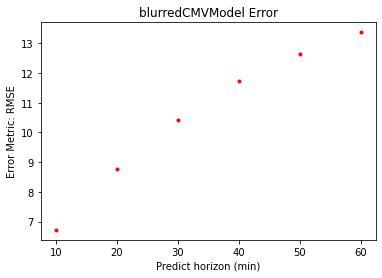

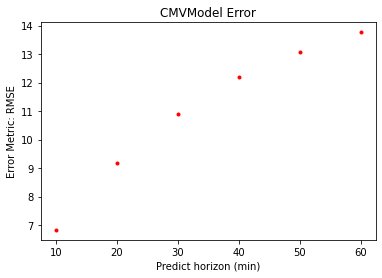

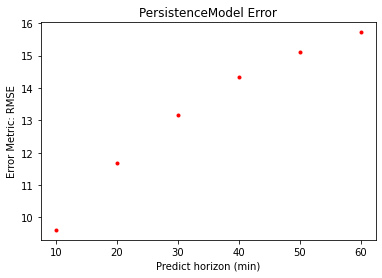

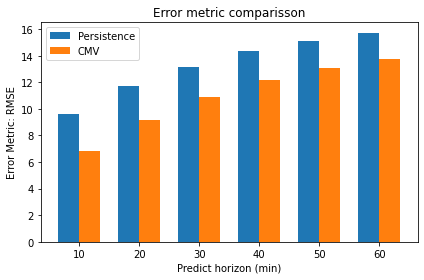

In [3]:
#Evaluate CMV and Persistence
normalize = preprocessing.normalize_pixels()
val_mvd = MontevideoFoldersDataset(path = PATH_DATA, in_channel = 2, out_channel=6,
                                     min_time_diff=5,max_time_diff=15)
                                     #transform = normalize)
val_loader = DataLoader(val_mvd)
metric = 'MSE'
print("metric:", metric)

cmv = model.Cmv2()
persistence = model.Persistence()
#blurredCMV = model.Cmv2(kernel_size=(7,7))

print('Predicting CMV')
time.sleep(1)
error_array_cmv = evaluate.evaluate_model(cmv, val_loader, 6, metric=metric)

print()
print('Predicting Persistence')
time.sleep(1)
error_array_p = evaluate.evaluate_model(persistence, val_loader, 6, metric=metric)

# print('Predicting Blurred CMV')
# time.sleep(1)
# error_array_blurred_cmv = evaluate.evaluate_model(blurredCMV, val_loader, 6, metric=metric)

# print('CMV predicted ', error_array_cmv.shape[1],  'images for' , error_array_cmv.shape[0], 'images')
# print('Persistence predicted ', error_array_p.shape[1], 'images for' , error_array_p.shape[0],'images')
# print('Blurred Persistence predicted ', error_array_bp.shape[1], 'images for' , error_array_bp.shape[0], 'images')

# error_mean_blurred_cmv = np.mean(error_array_blurred_cmv, axis=0)
error_mean_cmv = np.mean(error_array_cmv, axis=0)
error_mean_p = np.mean(error_array_p, axis=0)
# print(f'error_mean_blurred_cmv: {error_mean_blurred_cmv}')
print(f'Error_mean_cmv: {error_mean_cmv}')
print(f'Error_mean_p: {error_mean_p}')

# visualization.plot_graph(error_mean_blurred_cmv, model='blurredCMV')
visualization.plot_graph(error_mean_cmv, model='CMV')
visualization.plot_graph(error_mean_p, model='Persistence')

visualization.barchart_compare2(
                error_mean_p, 'Persistence',
                error_mean_cmv, 'CMV') 
                # error_mean_blurred_cmv, 'blurredCMV')

using device: cuda
Predicting Unet


Status: 100%|██████████| 2444/2444 [04:11<00:00,  9.74sequences/s]


Evaluation time: 3.48 seconds.
error_array_Unet: [6.5468289e-02 9.1186196e-02 1.4243025e-01 6.1921322e-01 8.1388960e+00
 1.3116161e+02]


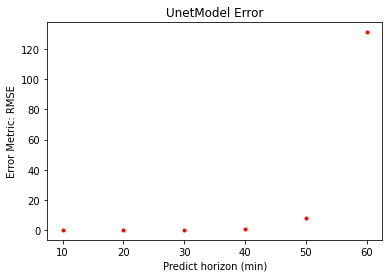

In [2]:
#Evaluate Unet
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('using device:', device)

normalize = preprocessing.normalize_pixels()

val_mvd = MontevideoFoldersDataset(path = PATH_DATA , in_channel = 3, out_channel=6,
                                  min_time_diff=5,max_time_diff=15,
                                     transform = normalize)
val_loader = DataLoader(val_mvd)

load_path = 'checkpoints/model_epoch20_18-06-2021_07_35.pt'

model_Unet = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)
model_Unet.load_state_dict(torch.load(load_path)["model_state_dict"])
model_Unet.eval()

print('Predicting Unet')
time.sleep(1)
error_array_Unet = evaluate.evaluate_model(model_Unet, val_loader, 6, device=device, metric='MBD')

error_mean_Unet = np.mean(error_array_Unet, axis=0)
print(f'error_array_Unet: {error_mean_Unet}')
visualization.plot_graph(error_mean_Unet, model='Unet')

In [9]:
np.set_printoptions(suppress=True)
print(f'error_array_Unet: {error_mean_Unet*10000}')

error_array_Unet: [ 61.52665  104.608406 153.29086  198.83469  244.9378   294.48273 ]


using device: cuda
Prediccion: 0


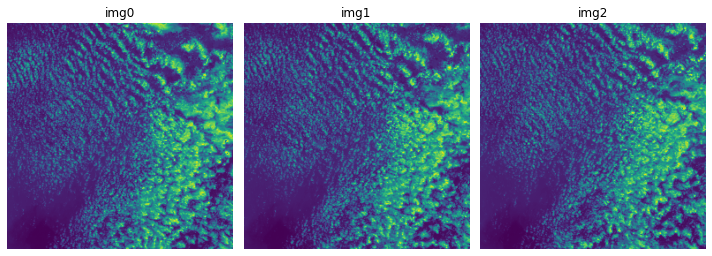

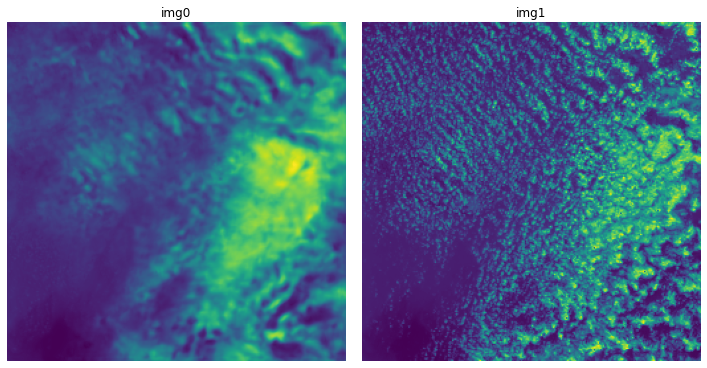

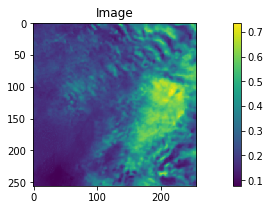

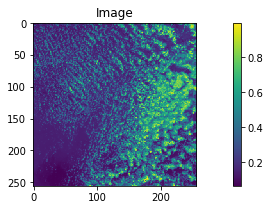

In [25]:
#Visualize predictions
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('using device:', device)

load_path = 'checkpoints/model_epoch20_18-06-2021_07:35.pt'
model_Unet = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)
model_Unet.load_state_dict(torch.load(load_path)["model_state_dict"])
model_Unet.eval()

val_mvd = MontevideoFoldersDataset(path = PATH_DATA, out_channel=6
                                    ,min_time_diff=5,max_time_diff=15,
                                     transform = normalize)
val_loader = DataLoader(val_mvd, shuffle=True)

predict_horizon = 1
for idx, (inputs, target) in enumerate(val_loader):
    for i in range(predict_horizon):
        print("Prediccion:", i)
        inputs = inputs.to(device=device)
        prediction = model_Unet(inputs)
        #Inputs
        visualization.show_image_list(inputs.cpu().detach().numpy().squeeze(), 1)
        #Prediction vs Target 
        visualization.show_image_list([prediction.cpu().detach().numpy().squeeze(), target.cpu().detach().numpy().squeeze()[i]], 1)
        #Prediction colorbar
        visualization.show_image_w_colorbar(prediction.cpu().detach().numpy().squeeze())
        #Target colorbar
        visualization.show_image_w_colorbar(target.cpu().detach().numpy().squeeze()[i])
    
        inputs = torch.cat((inputs.squeeze(0)[1:], prediction.squeeze(0)))
        inputs = inputs.unsqueeze(0)
    break

In [18]:
#Evaluate models with diferent metrics and save results in dictionary in a pickle file
val_mvd = MontevideoFoldersDataset(path = PATH_DATA, in_channel = 2, out_channel=6,
                                     min_time_diff=5,max_time_diff=15)#, csv_path=os.path.join(PATH_PROJECT,'data/mvd/val_cosangs_in2_out6.csv'))
val_loader = DataLoader(val_mvd)

normalize = preprocessing.normalize_pixels(mean0=False) 
val_mvd_Unet = MontevideoFoldersDataset(path = PATH_DATA, in_channel = 3, out_channel=6,
                                     min_time_diff=5,max_time_diff=15,
                                      transform = normalize)#, csv_path=os.path.join(PATH_PROJECT,'data/mvd/val_cosangs_in3_out6.csv'))
val_loader_Unet = DataLoader(val_mvd_Unet)

metrics = ['RMSE', 'RMSE%', 'MSE', 'MSE%', 'MAE', 'MAE%', 'MBD', 'MBD%']
errors_metrics = {}

#models
cmv = model.Cmv2()
blurredCMV = model.Cmv2(kernel_size=(29,29))
persistence = model.Persistence()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
load_path = 'checkpoints/model_epoch50_01-07-2021_22_35.pt'
model_Unet = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)
model_Unet.load_state_dict(torch.load(load_path)["model_state_dict"])
model_Unet.eval()

for metric in metrics:
    fix = 1
    #variables for percentage evaluation:
    percentage_pos = metric.find("%") 
    if percentage_pos != -1:
        end_metric = percentage_pos
        error_percentage=True
    else:
        end_metric = len(metric)
        error_percentage=False
        fix = fix*100
    #fix to normalize errors:
    if metric[:end_metric] == 'MSE':
        fix = fix*100

    errors_metric = {}
    print('Predicting CMV')
    time.sleep(1)
    error_array_cmv = evaluate.evaluate_model(cmv, val_loader, 6, metric=metric[:end_metric], error_percentage=error_percentage)
    
    print('Predicting Blurred CMV')
    time.sleep(1)
    error_array_Bcmv = evaluate.evaluate_model(blurredCMV, val_loader, 6, metric=metric[:end_metric], error_percentage=error_percentage)

    print('Predicting Persistence')
    time.sleep(1)
    error_array_p = evaluate.evaluate_model(persistence, val_loader, 6, metric=metric[:end_metric], error_percentage=error_percentage)

    print('Predicting Unet')
    time.sleep(1)
    error_array_Unet = evaluate.evaluate_model(model_Unet, val_loader_Unet, 6, device=device, metric=metric[:end_metric], error_percentage=error_percentage)

    error_mean_cmv = np.mean(error_array_cmv, axis=0)
    error_mean_Bcmv = np.mean(error_array_Bcmv, axis=0)
    error_mean_p = np.mean(error_array_p, axis=0)
    error_mean_Unet = np.mean(error_array_Unet, axis=0)

    print(f'Error_mean_cmv: {error_mean_cmv/fix}')
    print(f'Error_mean_Bcmv: {error_mean_Bcmv/fix}')
    print(f'Error_mean_p: {error_mean_p/fix}')
    print(f'error_array_Unet: {error_mean_Unet}')

    errors_metric['CMV'] = error_mean_cmv/fix
    errors_metric['BCMV'] = error_mean_Bcmv/fix
    errors_metric['Persistence'] = error_mean_p/fix
    errors_metric['Best Unet'] = error_mean_Unet
    errors_metrics[metric] = errors_metric

PATH = "reports/errors_evaluate_model/"
ts = datetime.datetime.now().strftime("%d-%m-%Y_%H-%M")
NAME = 'errors_models_' + str(ts) + '.pkl'

a_file = open(os.path.join(PATH, NAME), "wb")
pickle.dump(errors_metrics, a_file)
a_file.close()


Predicting CMV


Status: 100%|██████████| 2488/2488 [01:12<00:00, 34.16sequences/s]


Cmv predict time: 49.33 seconds.
Evaluation time: 6.80 seconds.
Predicting Blurred CMV


Status: 100%|██████████| 2488/2488 [01:21<00:00, 30.69sequences/s]


Cmv predict time: 58.27 seconds.
Evaluation time: 6.65 seconds.
Predicting Persistence


Status: 100%|██████████| 2488/2488 [00:20<00:00, 121.17sequences/s]


Persistence predict time: 2.26 seconds.
Evaluation time: 3.07 seconds.
Predicting Unet


Status: 100%|██████████| 2444/2444 [03:15<00:00, 12.47sequences/s]


Evaluation time: 3.11 seconds.
Error_mean_cmv: [0.06829895 0.09172943 0.1088778  0.12200282 0.13073805 0.13768569]
Error_mean_Bcmv: [0.07178673 0.08810739 0.10281485 0.11503704 0.12351497 0.13045977]
Error_mean_p: [0.09613076 0.11686369 0.13176307 0.14335272 0.15110011 0.15723705]
error_array_Unet: [0.05912541 0.08013999 0.09787883 0.11162048 0.12351853 0.13452342]
Predicting CMV


Status: 100%|██████████| 2488/2488 [01:12<00:00, 34.33sequences/s]


Cmv predict time: 48.99 seconds.
Evaluation time: 7.27 seconds.
Predicting Blurred CMV


Status: 100%|██████████| 2488/2488 [01:25<00:00, 29.13sequences/s]


Cmv predict time: 60.89 seconds.
Evaluation time: 7.56 seconds.
Predicting Persistence


Status: 100%|██████████| 2488/2488 [00:22<00:00, 110.45sequences/s]


Persistence predict time: 2.34 seconds.
Evaluation time: 4.05 seconds.
Predicting Unet


Status: 100%|██████████| 2444/2444 [03:31<00:00, 11.54sequences/s]


Evaluation time: 3.94 seconds.
Error_mean_cmv: [0.2699961  0.35992333 0.43124896 0.4946513  0.5583328  0.6457526 ]
Error_mean_Bcmv: [0.2877672  0.34675995 0.4061304  0.46381328 0.5241916  0.6084431 ]
Error_mean_p: [0.37338784 0.45509112 0.51974535 0.5794745  0.64254105 0.7313202 ]
error_array_Unet: [0.2317234  0.30933332 0.37701288 0.43783805 0.50247115 0.58183163]
Predicting CMV


Status: 100%|██████████| 2488/2488 [01:13<00:00, 33.82sequences/s]


Cmv predict time: 49.98 seconds.
Evaluation time: 6.86 seconds.
Predicting Blurred CMV


Status: 100%|██████████| 2488/2488 [01:24<00:00, 29.33sequences/s]


Cmv predict time: 60.80 seconds.
Evaluation time: 6.97 seconds.
Predicting Persistence


Status: 100%|██████████| 2488/2488 [00:21<00:00, 114.46sequences/s]


Persistence predict time: 2.32 seconds.
Evaluation time: 3.35 seconds.
Predicting Unet


Status: 100%|██████████| 2444/2444 [03:22<00:00, 12.09sequences/s]


Evaluation time: 3.27 seconds.
Error_mean_cmv: [0.0073383  0.01307368 0.01850641 0.02340251 0.02670558 0.02924183]
Error_mean_Bcmv: [0.00778758 0.01203706 0.01671169 0.0211927  0.02426168 0.02665472]
Error_mean_p: [0.01380772 0.01998661 0.02537723 0.03020342 0.0334776  0.03594198]
error_array_Unet: [0.00542281 0.00977476 0.01409473 0.01781454 0.02144413 0.02529675]
Predicting CMV


Status: 100%|██████████| 2488/2488 [01:13<00:00, 33.80sequences/s]


Cmv predict time: 49.69 seconds.
Evaluation time: 7.37 seconds.
Predicting Blurred CMV


Status: 100%|██████████| 2488/2488 [01:24<00:00, 29.30sequences/s]


Cmv predict time: 60.51 seconds.
Evaluation time: 7.50 seconds.
Predicting Persistence


Status: 100%|██████████| 2488/2488 [00:21<00:00, 116.51sequences/s]


Persistence predict time: 2.23 seconds.
Evaluation time: 3.80 seconds.
Predicting Unet


Status: 100%|██████████| 2444/2444 [03:24<00:00, 11.94sequences/s]


Evaluation time: 3.86 seconds.
Error_mean_cmv: [0.02287108 0.04070585 0.05955046 0.07880314 0.09792189 0.12490255]
Error_mean_Bcmv: [0.0246127  0.0370202  0.05267482 0.06977894 0.08716789 0.11211556]
Error_mean_p: [0.0434196  0.06313881 0.08243098 0.10224778 0.12252446 0.15107188]
error_array_Unet: [0.01738737 0.0302855  0.04350004 0.05604822 0.07009441 0.08827291]
Predicting CMV


Status: 100%|██████████| 2488/2488 [01:14<00:00, 33.45sequences/s]


Cmv predict time: 50.52 seconds.
Evaluation time: 6.96 seconds.
Predicting Blurred CMV


Status: 100%|██████████| 2488/2488 [01:26<00:00, 28.67sequences/s]


Cmv predict time: 62.17 seconds.
Evaluation time: 7.15 seconds.
Predicting Persistence


Status: 100%|██████████| 2488/2488 [00:22<00:00, 112.31sequences/s]


Persistence predict time: 2.34 seconds.
Evaluation time: 3.43 seconds.
Predicting Unet


Status: 100%|██████████| 2444/2444 [03:30<00:00, 11.60sequences/s]


Evaluation time: 3.22 seconds.
Error_mean_cmv: [0.04388994 0.06168624 0.07544211 0.0865164  0.09428848 0.1004748 ]
Error_mean_Bcmv: [0.04835749 0.06153476 0.07351667 0.0838016  0.09122071 0.09723593]
Error_mean_p: [0.06147213 0.07781122 0.09019139 0.1002822  0.10737416 0.11297389]
error_array_Unet: [0.0366904  0.05269027 0.06778619 0.08056656 0.09178524 0.10213217]
Predicting CMV


Status: 100%|██████████| 2488/2488 [01:15<00:00, 33.00sequences/s]


Cmv predict time: 50.75 seconds.
Evaluation time: 7.64 seconds.
Predicting Blurred CMV


Status: 100%|██████████| 2488/2488 [01:26<00:00, 28.76sequences/s]


Cmv predict time: 61.44 seconds.
Evaluation time: 7.74 seconds.
Predicting Persistence


Status: 100%|██████████| 2488/2488 [00:22<00:00, 109.61sequences/s]


Persistence predict time: 2.32 seconds.
Evaluation time: 4.08 seconds.
Predicting Unet


Status: 100%|██████████| 2444/2444 [03:32<00:00, 11.52sequences/s]


Evaluation time: 3.93 seconds.
Error_mean_cmv: [0.15707394 0.21981178 0.27298522 0.32338873 0.377659   0.45361516]
Error_mean_Bcmv: [0.17926611 0.22454275 0.27028948 0.3167293  0.36843997 0.4419752 ]
Error_mean_p: [0.21261933 0.27097836 0.32030094 0.36846885 0.42211595 0.49817964]
error_array_Unet: [0.12677792 0.1814791  0.23725432 0.2928908  0.35233194 0.42467803]
Predicting CMV


Status: 100%|██████████| 2488/2488 [01:12<00:00, 34.11sequences/s]


Cmv predict time: 49.71 seconds.
Evaluation time: 6.65 seconds.
Predicting Blurred CMV


Status: 100%|██████████| 2488/2488 [01:23<00:00, 29.63sequences/s]


Cmv predict time: 60.49 seconds.
Evaluation time: 6.72 seconds.
Predicting Persistence


Status: 100%|██████████| 2488/2488 [00:21<00:00, 116.97sequences/s]


Persistence predict time: 2.30 seconds.
Evaluation time: 3.12 seconds.
Predicting Unet


Status: 100%|██████████| 2444/2444 [03:27<00:00, 11.80sequences/s]


Evaluation time: 3.07 seconds.
Error_mean_cmv: [-0.00269577 -0.00448065 -0.0049828  -0.00455439 -0.00183584  0.00206742]
Error_mean_Bcmv: [-0.0051608  -0.00791706 -0.00899186 -0.0089603  -0.00655095 -0.00291747]
Error_mean_p: [-2.8012004e-03 -4.4071199e-03 -4.4990163e-03 -3.4895348e-03
 -2.1436033e-05  4.7383229e-03]
error_array_Unet: [-0.00950447 -0.0214629  -0.03187331 -0.03872153 -0.04264488 -0.04447183]
Predicting CMV


Status: 100%|██████████| 2488/2488 [01:15<00:00, 33.13sequences/s]


Cmv predict time: 50.87 seconds.
Evaluation time: 7.44 seconds.
Predicting Blurred CMV


Status: 100%|██████████| 2488/2488 [01:21<00:00, 30.53sequences/s]


Cmv predict time: 58.37 seconds.
Evaluation time: 7.07 seconds.
Predicting Persistence


Status: 100%|██████████| 2488/2488 [00:20<00:00, 119.09sequences/s]


Persistence predict time: 2.20 seconds.
Evaluation time: 3.55 seconds.
Predicting Unet


Status: 100%|██████████| 2444/2444 [03:19<00:00, 12.25sequences/s]

Evaluation time: 3.63 seconds.
Error_mean_cmv: [-0.0137748  -0.01269833  0.00293152  0.02940078  0.06862989  0.13259973]
Error_mean_Bcmv: [-0.02133693 -0.02407842 -0.01091677  0.01365203  0.05113439  0.11304264]
Error_mean_p: [-0.0142314  -0.01243039  0.00511284  0.03482499  0.07860161  0.14797553]
error_array_Unet: [-0.02801448 -0.05585629 -0.07266577 -0.07271466 -0.05829349 -0.02223112]


In [ ]:
#Load results from dictionary in a pickle file and display graphs
errors_file = open("reports/errors_evaluate_model/errors_models_02-07-2021_21-32(cosangs).pkl", "rb") # unet: model_epoch20_25-06-2021_02_48.pt
errors_metrics = pickle.load(errors_file)
errors_file.close()

for metric, errors_metric in errors_metrics.items():
    error_list = []
    models = []
    for model_name, error in errors_metric.items():
        error_list.append(errors_metrics[metric][model_name])
        models.append(model_name)
    visualization.plot_graph_multiple(error_list, models, error_metric=metric, save_file="reports/" + metric)
  